In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

In [2]:
YEARS = range(1999, 2025)

In [3]:
'''
data_list = []

for i in YEARS:  
    i_data = pd.read_csv('https://github.com/nflverse/nflverse-data/releases/download/pbp/' \
                   'play_by_play_' + str(i) + '.csv.gz',
                   compression= 'gzip', low_memory= False)
    i_data['year'] = i
    data_list.append(i_data)

data = pd.concat(data_list, ignore_index=True, sort=True)

data.to_pickle('../data/nfl_pbp_data.pkl')
data.to_csv('../data/nfl_pbp_data.csv')
'''

data = pd.read_pickle('../data/nfl_pbp_data.pkl')

In [4]:
data

,aborted_play,air_epa,air_wpa,air_yards,assist_tackle,assist_tackle_1_player_id,assist_tackle_1_player_name,assist_tackle_1_team,assist_tackle_2_player_id,assist_tackle_2_player_name,...,xyac_success,yac_epa,yac_wpa,yardline_100,yards_after_catch,yards_gained,ydsnet,ydstogo,year,yrdln
0,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,30.0,NaN,0.0,6.0,0,1999,ARI 30
1,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,77.0,NaN,0.0,6.0,10,1999,PHI 23
2,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,77.0,NaN,1.0,6.0,10,1999,PHI 23
3,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,76.0,NaN,0.0,6.0,9,1999,PHI 24
4,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,81.0,NaN,10.0,6.0,14,1999,PHI 19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230674,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,64.0,NaN,1.0,7.0,4,2024,WAS 36
1230675,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,63.0,NaN,0.0,7.0,3,2024,WAS 37
1230676,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,37.0,NaN,-2.0,-3.0,10,2024,WAS 37
1230677,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,39.0,NaN,-1.0,-3.0,12,2024,WAS 39


In [5]:
def passer_rating(cmp, pass_yds, tds, ints, att):
    a = (cmp/att - .3) * 5
    b = (pass_yds/att - 3) * .25
    c = (tds/att) * 20
    d = 2.375 - (25 * ints/att)

    return ((a+b+c+d)/6) * 100

def anya(pass_yds, tds, ints, sack_yds, sacks, pass_attempts):
    return (pass_yds + (tds * 20) - (ints * 45) - sack_yds)/(pass_attempts + sacks)

In [6]:
#decided to focus on passer rating, ANY/A and EPA as stats.

data['short_pass'] = data["pass_length"] == "short"
data['rush_epa'] = np.where(data['rush_attempt'] == 1, data['epa'], np.nan)

data['sack_yards'] = np.where(data['sack'] == 1, data['yards_gained'], 0)
game_data = data.groupby(['game_id', 'passer_player_name']).agg({'air_yards' : 'sum', 
                                                                 'yards_after_catch' : 'sum',
                                                                 'yards_gained' : 'sum',
                                                                 'rushing_yards': 'sum',
                                                                 'sack_yards' : 'sum',
                                                                 'touchdown' : 'sum',
                                                                 'complete_pass' : 'sum', 
                                                                 'interception' : 'sum', 
                                                                 'pass_attempt' : 'sum', 
                                                                 'sack' : 'sum',
                                                                 'qb_dropback' : 'sum',
                                                                 'qb_epa' : 'mean',
                                                                 'rush_epa' : 'mean',
                                                                 'home_team': 'first',
                                                                 'away_team': 'first',
                                                                 'year' : 'first',
                                                                 'short_pass' : 'sum',
                                                                 'posteam' : 'first'}).reset_index()
sack_data = data[data['sack']==1]
#sack_data
game_data['any_a'] = game_data.apply(lambda row: anya(pass_yds=row['air_yards'], tds=row['touchdown'], ints=row['interception'], sack_yds=row['sack_yards'], sacks=row['sack'], pass_attempts=row['pass_attempt']), axis = 1)
game_data['passer_rating'] = game_data.apply(lambda row: passer_rating(cmp = row['complete_pass'], pass_yds = row['air_yards'], tds = row['touchdown'], ints = row['interception'], att = row['pass_attempt']), axis = 1)
game_data['percent_pass_yds_from_yac'] = np.where(game_data['yards_gained'] != 0, game_data['yards_after_catch'] / game_data['yards_gained'], np.nan)
game_data['sacks_per_dropback'] = game_data['sack'] / game_data['qb_dropback']
game_data['percent_short_pass'] = np.where(game_data['pass_attempt'] != 0, game_data['short_pass'] / game_data['pass_attempt'], np.nan)


C:\Users\irela\AppData\Local\Temp\ipykernel_15592\326327977.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['short_pass'] = data["pass_length"] == "short"
C:\Users\irela\AppData\Local\Temp\ipykernel_15592\326327977.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['rush_epa'] = np.where(data['rush_attempt'] == 1, data['epa'], np.nan)
C:\Users\irela\AppData\Local\Temp\ipykernel_15592\326327977.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times

In [ ]:
primary_passers = data.loc[
    data.groupby(['game_id', 'posteam'])['pass_attempt'].idxmax()
][['game_id', 'posteam', 'passer_player_name']]

team_rush_epa = (
    data.groupby(['game_id', 'posteam'])['rush_epa']
    .mean()
    .reset_index()
    .rename(columns = {'rush_epa' : 'team_rush_epa'})
)

primary_data = primary_passers.merge(team_rush_epa, on=['game_id', 'posteam'])
game_data = primary_data.merge(game_data, on=['game_id', 'passer_player_name'])
game_data[['game_id', 'passer_player_name', 'team_rush_epa']]

In [9]:
game_data['team_rush_epa']

0       -0.279451
1        0.065022
2       -0.111319
3       -0.341237
4       -0.072226
           ...   
13969    0.029897
13970    0.112297
13971   -0.117321
13972    0.192977
13973   -0.046009
Name: team_rush_epa, Length: 13974, dtype: float64

(array([2.000e+00, 0.000e+00, 1.300e+01, 8.900e+01, 7.640e+02, 3.629e+03,
        4.348e+03, 1.150e+03, 1.220e+02, 9.000e+00]),
 array([-2.37098798, -1.97468304, -1.5783781 , -1.18207316, -0.78576822,
        -0.38946328,  0.00684166,  0.4031466 ,  0.79945154,  1.19575648,
         1.59206142]),
 <BarContainer object of 10 artists>)

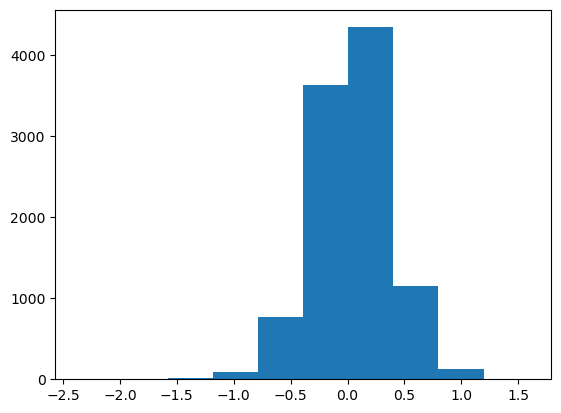

In [10]:
qb_game_data = game_data[(game_data['pass_attempt'] > 10) & (game_data['air_yards']>0)]
plt.hist(qb_game_data['qb_epa'])

In [11]:
'''
qb_game_columns = qb_game_data.columns.to_list()
for col in qb_game_columns:
    if pd.api.types.is_numeric_dtype(qb_game_data[col]):
        plt.hist(qb_game_data[col])
        plt.title(col)
        plt.show();
'''

'\nqb_game_columns = qb_game_data.columns.to_list()\nfor col in qb_game_columns:\n    if pd.api.types.is_numeric_dtype(qb_game_data[col]):\n        plt.hist(qb_game_data[col])\n        plt.title(col)\n        plt.show();\n'

In [12]:
qb_game_data.to_csv("../data/qb_game_data.csv")

In [13]:
qb_game_data.columns

Index(['game_id', 'posteam_x', 'passer_player_name', 'team_rush_epa',
       'air_yards', 'yards_after_catch', 'yards_gained', 'rushing_yards',
       'sack_yards', 'touchdown', 'complete_pass', 'interception',
       'pass_attempt', 'sack', 'qb_dropback', 'qb_epa', 'rush_epa',
       'home_team', 'away_team', 'year', 'short_pass', 'posteam_y', 'any_a',
       'passer_rating', 'percent_pass_yds_from_yac', 'sacks_per_dropback',
       'percent_short_pass'],
      dtype='object')

In [14]:
import statsmodels.formula.api as smf

epa_model = smf.ols('qb_epa ~ air_yards + yards_after_catch + rushing_yards + sack_yards + touchdown + complete_pass + interception + pass_attempt + sack + qb_dropback + passer_rating', data=qb_game_data).fit()
print(epa_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 qb_epa   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     3570.
Date:                Wed, 05 Feb 2025   Prob (F-statistic):               0.00
Time:                        15:53:00   Log-Likelihood:                 4530.7
No. Observations:               10126   AIC:                            -9039.
Df Residuals:                   10115   BIC:                            -8960.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.0758      0.02

In [15]:
anya_model = smf.ols('any_a ~ air_yards + yards_after_catch + rushing_yards + sack_yards + touchdown + complete_pass + interception + pass_attempt + sack + qb_dropback + passer_rating', data=qb_game_data).fit()
print(anya_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  any_a   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                 2.760e+04
Date:                Wed, 05 Feb 2025   Prob (F-statistic):               0.00
Time:                        15:53:00   Log-Likelihood:                -6233.2
No. Observations:               10126   AIC:                         1.249e+04
Df Residuals:                   10115   BIC:                         1.257e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.9506      0.05

In [16]:
purdy_data = qb_game_data[qb_game_data['passer_player_name']=='B.Purdy']
garoppolo_data = qb_game_data[(qb_game_data['passer_player_name']=='J.Garoppolo') & ((qb_game_data['home_team'] == 'SF') | (qb_game_data['away_team'] == 'SF'))]

# top ten QB APY for 2024 accoridng to https://overthecap.com/position/quarterback
ten_highest_paid_qbs = ['D.Prescott', 'J.Burrow', 'J.Love', 'T.Lawrence', 'T.Tagovailoa', 'J.Goff', 'J.Herbert', 'L.Jackson', 'J.Hurts', 'K.Murray']
top_ten_data = qb_game_data[qb_game_data['passer_player_name'].isin(ten_highest_paid_qbs)]

top_ten_data

,game_id,posteam_x,passer_player_name,team_rush_epa,air_yards,yards_after_catch,yards_gained,rushing_yards,sack_yards,touchdown,...,home_team,away_team,year,short_pass,posteam_y,any_a,passer_rating,percent_pass_yds_from_yac,sacks_per_dropback,percent_short_pass
9046,2016_01_NYG_DAL,DAL,D.Prescott,-0.071850,406.0,76.0,227.0,0.0,0.0,0.0,...,DAL,NYG,2016,33,DAL,9.022222,85.972222,0.334802,0.000000,0.733333
9062,2016_02_DAL_WAS,DAL,D.Prescott,-0.153727,191.0,157.0,278.0,0.0,-14.0,0.0,...,WAS,DAL,2016,28,DAL,5.394737,79.411765,0.564748,0.117647,0.823529
9095,2016_03_CHI_DAL,DAL,D.Prescott,0.134589,217.0,93.0,248.0,0.0,0.0,1.0,...,DAL,CHI,2016,18,DAL,9.875000,119.618056,0.375000,0.000000,0.750000
9126,2016_04_DAL_SF,DAL,D.Prescott,0.115401,179.0,129.0,234.0,0.0,-11.0,2.0,...,SF,DAL,2016,31,DAL,6.388889,100.000000,0.551282,0.058824,0.911765
9159,2016_05_CIN_DAL,DAL,D.Prescott,0.154513,150.0,104.0,222.0,0.0,-5.0,1.0,...,DAL,CIN,2016,20,DAL,6.730769,100.416667,0.468468,0.040000,0.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13958,2024_19_PIT_BAL,BAL,L.Jackson,0.134920,118.0,86.0,165.0,0.0,-10.0,2.0,...,BAL,PIT,2024,18,BAL,7.304348,115.340909,0.521212,0.047619,0.818182
13962,2024_20_BAL_BUF,BAL,L.Jackson,0.293517,260.0,85.0,240.0,0.0,-14.0,2.0,...,BUF,BAL,2024,19,BAL,8.677419,99.784483,0.354167,0.068966,0.655172
13967,2024_20_LA_PHI,PHI,J.Hurts,0.286128,129.0,86.0,65.0,0.0,-63.0,0.0,...,PHI,LA,2024,18,PHI,5.647059,68.287037,1.323077,0.259259,0.666667
13968,2024_20_WAS_DET,DET,J.Goff,0.503885,331.0,153.0,297.0,0.0,-16.0,2.0,...,DET,WAS,2024,31,DET,5.727273,66.666667,0.515152,0.051282,0.738095


In [17]:
for i in data.columns:
    print(i)

aborted_play
air_epa
air_wpa
air_yards
assist_tackle
assist_tackle_1_player_id
assist_tackle_1_player_name
assist_tackle_1_team
assist_tackle_2_player_id
assist_tackle_2_player_name
assist_tackle_2_team
assist_tackle_3_player_id
assist_tackle_3_player_name
assist_tackle_3_team
assist_tackle_4_player_id
assist_tackle_4_player_name
assist_tackle_4_team
away_coach
away_score
away_team
away_timeouts_remaining
away_wp
away_wp_post
blocked_player_id
blocked_player_name
comp_air_epa
comp_air_wpa
comp_yac_epa
comp_yac_wpa
complete_pass
cp
cpoe
def_wp
defensive_extra_point_attempt
defensive_extra_point_conv
defensive_two_point_attempt
defensive_two_point_conv
defteam
defteam_score
defteam_score_post
defteam_timeouts_remaining
desc
div_game
down
drive
drive_end_transition
drive_end_yard_line
drive_ended_with_score
drive_first_downs
drive_game_clock_end
drive_game_clock_start
drive_inside20
drive_play_count
drive_play_id_ended
drive_play_id_started
drive_quarter_end
drive_quarter_start
drive_real

In [18]:
def plot_qb_purdy_ten(qb_df=qb_game_data, purdy_df=purdy_data, top_ten_df=top_ten_data, x_label='air_yards', y_label='passer_rating', include_garopollo = False):
    plt.scatter(x=qb_df[x_label], y=qb_df[y_label], color = 'gray', alpha=.5, label='All other QBs')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.scatter(x=top_ten_df[x_label], y=top_ten_df[y_label], color = 'green', alpha=.5, label='Top 10 Highest Paid QBs')
    plt.scatter(x=purdy_df[x_label], y=purdy_df[y_label], color = 'red', alpha=.7, label='Purdy')
    if include_garopollo:
        plt.scatter(x=garoppolo_data[x_label], y=garoppolo_data[y_label], color = 'orange', alpha=.7, label='Garopollo with the 49ers')
    plt.legend()
    plt.show();

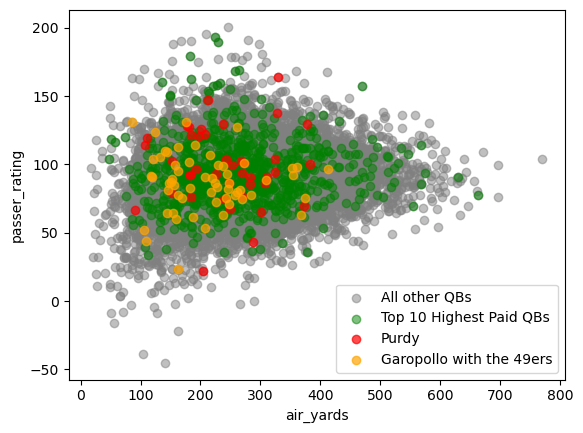

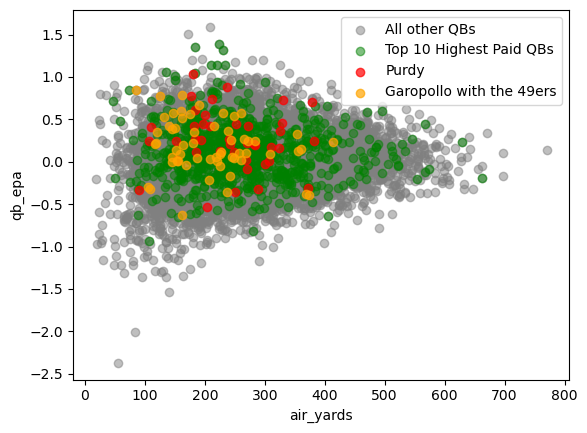

KeyError: 'any/a'

In [19]:
plot_qb_purdy_ten(x_label='air_yards', y_label='passer_rating', include_garopollo=True)

plot_qb_purdy_ten(x_label='air_yards', y_label='qb_epa', include_garopollo=True)

plot_qb_purdy_ten(x_label='air_yards', y_label='any/a', include_garopollo=True)

plot_qb_purdy_ten(x_label='passer_rating', y_label='qb_epa', include_garopollo=True)

In [68]:
# shannahan QBs

#team = SF & 2017-2025
#ATL & 2015-2016
#CLE & 2014
#WAS & 2010-2013
#HOU & 2008-2009

shanahan_data = qb_game_data[(((qb_game_data["year"] >= 2017) & (qb_game_data["year"] <= 2025)) & ((qb_game_data['home_team'] == 'SF') | (qb_game_data['away_team'] == 'SF'))) |
                             (((qb_game_data["year"] >= 2015) & (qb_game_data["year"] <= 2016)) & ((qb_game_data['home_team'] == 'ATL') | (qb_game_data['away_team'] == 'ATL'))) |
                             ((qb_game_data["year"] == 2014) & ((qb_game_data['home_team'] == 'CLE') | (qb_game_data['away_team'] == 'CLE'))) |
                             (((qb_game_data["year"] >= 2010) & (qb_game_data["year"] <= 2013)) & ((qb_game_data['home_team'] == 'WAS') | (qb_game_data['away_team'] == 'WAS'))) |
                             (((qb_game_data["year"] >= 2008) & (qb_game_data["year"] <= 2009)) & ((qb_game_data['home_team'] == 'HOU') | (qb_game_data['away_team'] == 'HOU')))
                             ]
shanahan_data #doesn't work

,game_id,passer_player_name,air_yards,yards_after_catch,yards_gained,rushing_yards,sack_yards,touchdown,complete_pass,interception,pass_attempt,sack,qb_dropback,qb_epa,home_team,away_team,year,any_a,passer_rating
6029,2008_01_HOU_PIT,B.Roethlisberger,75.0,68.0,122.0,0.0,-15.0,2.0,13.0,0.0,16.0,2.0,16.0,0.165374,PIT,HOU,2008,7.222222,130.989583
6030,2008_01_HOU_PIT,M.Schaub,198.0,57.0,159.0,0.0,-43.0,1.0,25.0,2.0,38.0,5.0,38.0,-0.260174,PIT,HOU,2008,3.976744,65.460526
6103,2008_03_HOU_TEN,K.Collins,270.0,73.0,189.0,0.0,0.0,1.0,14.0,1.0,26.0,0.0,26.0,0.002437,TEN,HOU,2008,9.423077,87.019231
6104,2008_03_HOU_TEN,M.Schaub,338.0,90.0,171.0,0.0,-17.0,1.0,17.0,3.0,40.0,3.0,40.0,-0.585769,TEN,HOU,2008,5.581395,49.791667
6144,2008_04_HOU_JAX,D.Garrard,219.0,93.0,236.0,0.0,0.0,1.0,23.0,0.0,33.0,1.0,33.0,0.255991,JAX,HOU,2008,7.029412,97.916667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17116,2024_16_SF_MIA,T.Tagovailoa,197.0,144.0,215.0,0.0,0.0,1.0,22.0,0.0,34.0,0.0,34.0,0.166246,MIA,SF,2024,6.382353,89.950980
17137,2024_17_DET_SF,B.Purdy,325.0,164.0,365.0,0.0,-12.0,3.0,27.0,2.0,37.0,2.0,36.0,0.360135,SF,DET,2024,7.871795,103.997748
17139,2024_17_DET_SF,J.Goff,147.0,129.0,289.0,0.0,-16.0,3.0,26.0,0.0,37.0,2.0,37.0,0.592462,SF,DET,2024,5.717949,104.222973
17203,2024_18_SF_ARI,J.Dobbs,335.0,97.0,298.0,0.0,-28.0,2.0,29.0,2.0,45.0,2.0,44.0,0.061820,ARI,SF,2024,6.659574,83.101852


In [ ]:
def compare_stat(qb1_df=purdy_data, qb2_data=garoppolo_data, stat_col='qb_epa'):
    stat, p_value = stats.ttest_ind(qb1_df[stat_col], qb2_data[stat_col], equal_var=False)
    print(f"{stat_col}")
    print(f"t_stat = {stat}")
    print(f"pvalue = {p_value}")
    if p_value < .05:
        print("The difference is statistically significant")
    print()

for i in qb_game_data.select_dtypes(include='number').columns:
    compare_stat(stat_col = i)

# Purdy vs Garoppolo

air_yards
t_stat = 2.123775967610814
pvalue = 0.036419888801141935
The difference is statistically significant

yards_after_catch
t_stat = -1.171598309203639
pvalue = 0.2442879031808086

yards_gained
t_stat = 1.4132684730456246
pvalue = 0.16096234020470593

rushing_yards
t_stat = nan
pvalue = nan

sack_yards
t_stat = 1.498406790085685
pvalue = 0.13718251523279962

touchdown
t_stat = 0.9982296819415398
pvalue = 0.3210805468071826

complete_pass
t_stat = -0.020933088740567173
pvalue = 0.9833407644078691

interception
t_stat = -0.8800385154125501
pvalue = 0.38144597199334196

pass_attempt
t_stat = -0.1534730312145092
pvalue = 0.8783350715514952

sack
t_stat = -0.6470300005091364
pvalue = 0.5191113669493944

qb_epa
t_stat = 0.9798274827024388
pvalue = 0.3300454175053784

any/a
t_stat = 3.2122520571924387
pvalue = 0.002096798224355494
The difference is statistically significant

passer_rating
t_stat = 2.270755259506077
pvalue = 0.026141154676367066
The difference is statistically significan

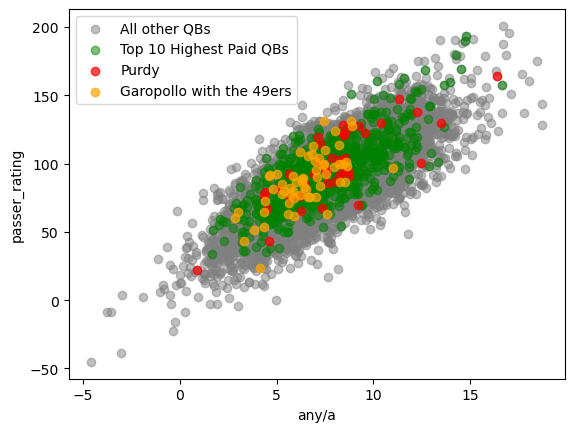

In [ ]:
plot_qb_purdy_ten(x_label='any/a', y_label='passer_rating', include_garopollo=True)
#statistically significant on both ends: any/a and passer_rating

In [ ]:
for i in qb_game_data.select_dtypes(include='number').columns:
    compare_stat(qb1_df = garoppolo_data, qb2_data = top_ten_data, stat_col = i)

# Garoppolo vs top 10

air_yards
t_stat = -5.04257691583958
pvalue = 3.2304502272015805e-06
The difference is statistically significant

yards_after_catch
t_stat = 2.043136643473341
pvalue = 0.04507457900227153
The difference is statistically significant

yards_gained
t_stat = -0.7228514231824565
pvalue = 0.47218956781247723

rushing_yards
t_stat = nan
pvalue = nan

sack_yards
t_stat = 0.3632620925034731
pvalue = 0.7175419869996685

touchdown
t_stat = -1.7268270082445265
pvalue = 0.08855277262669775

complete_pass
t_stat = -3.449817626489352
pvalue = 0.000949615734636239
The difference is statistically significant

interception
t_stat = 1.1714718582093437
pvalue = 0.2454706568067863

pass_attempt
t_stat = -4.22896935162423
pvalue = 6.865527613143244e-05
The difference is statistically significant

sack
t_stat = -0.45615270664032703
pvalue = 0.6497497739177703

qb_epa
t_stat = 1.7095208059467593
pvalue = 0.0919241069997638

any/a
t_stat = -4.513679463558411
pvalue = 2.2727652494008088e-05
The difference is st

In [ ]:
for i in qb_game_data.select_dtypes(include='number').columns:
    compare_stat(qb2_data = top_ten_data, stat_col = i)

# Purdy vs top 10

air_yards
t_stat = -1.7339724482009993
pvalue = 0.08930410249019627

yards_after_catch
t_stat = 0.37385579499061783
pvalue = 0.7102660905370118

yards_gained
t_stat = 1.1809949266608444
pvalue = 0.24356521103298454

rushing_yards
t_stat = nan
pvalue = nan

sack_yards
t_stat = 2.601101247968342
pvalue = 0.012247498956297297
The difference is statistically significant

touchdown
t_stat = -0.11498285049420968
pvalue = 0.9089627300105924

complete_pass
t_stat = -4.010791957656523
pvalue = 0.00019293718252819534
The difference is statistically significant

interception
t_stat = -0.19433652053152575
pvalue = 0.8467969387288619

pass_attempt
t_stat = -5.014261138388398
pvalue = 6.4404557518788785e-06
The difference is statistically significant

sack
t_stat = -1.406599507115986
pvalue = 0.16602443580616377

qb_epa
t_stat = 2.5068076316261956
pvalue = 0.015911667527914154
The difference is statistically significant

any/a
t_stat = 1.1580530994316396
pvalue = 0.25310196207447533

passer_rating
t

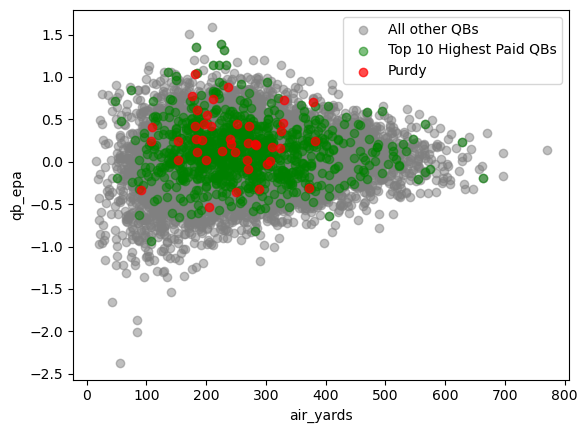

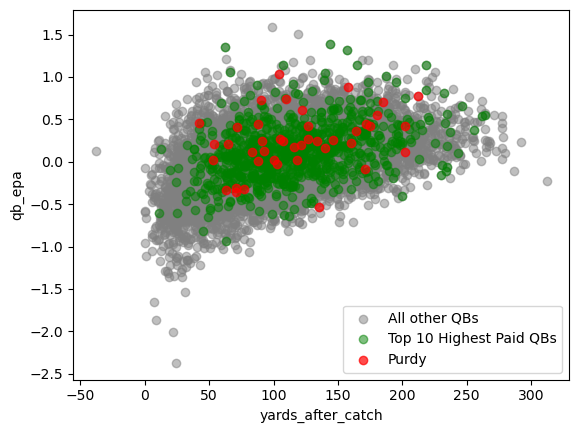

statistically significant:
top ten highest paid epa: 0.11631430162660313
purdy epa: 0.2521492690087716


In [ ]:
plot_qb_purdy_ten(x_label='air_yards', y_label='qb_epa')
plot_qb_purdy_ten(x_label='yards_after_catch', y_label='qb_epa')
print("statistically significant:")
print(f"top ten highest paid epa: {top_ten_data['qb_epa'].mean()}")
print(f"purdy epa: {purdy_data['qb_epa'].mean()}")

In [ ]:
for i in qb_game_data.select_dtypes(include='number').columns:
    compare_stat(qb2_data = qb_game_data, stat_col = i)

# Purdy vs all other qbs

air_yards
t_stat = -2.3540944720179744
pvalue = 0.02336378211008362
The difference is statistically significant

yards_after_catch
t_stat = 2.0675288812927337
pvalue = 0.044980805411977694
The difference is statistically significant

yards_gained
t_stat = 2.854657487268537
pvalue = 0.006695486714132344
The difference is statistically significant

rushing_yards
t_stat = nan
pvalue = nan

sack_yards
t_stat = 3.089550629477175
pvalue = 0.003562595589481018
The difference is statistically significant

touchdown
t_stat = 0.8895213501144191
pvalue = 0.3788696882302487

complete_pass
t_stat = -1.4412727030582995
pvalue = 0.1569273751449224

interception
t_stat = -1.2755841466962572
pvalue = 0.20922496795170642

pass_attempt
t_stat = -4.2729155810789115
pvalue = 0.00010846064856575907
The difference is statistically significant

sack
t_stat = -1.8612119375983551
pvalue = 0.06979260697527494

qb_epa
t_stat = 4.0206203062296435
pvalue = 0.00024074402241064114
The difference is statistically sign

In [22]:
print("statistically significant:")
print(f"all other qb epa: {qb_game_data['qb_epa'].mean()}")
print(f"purdy epa: {purdy_data['qb_epa'].mean()}")
print(f"all other qb passer_rating: {qb_game_data['passer_rating'].mean()}")
print(f"purdy passer_rating: {purdy_data['passer_rating'].mean()}")

statistically significant:
all other qb epa: 0.038233025080929454
purdy epa: 0.2521492690087716
all other qb passer_rating: 87.74449669264654
purdy passer_rating: 98.24383512215383


<Axes: >

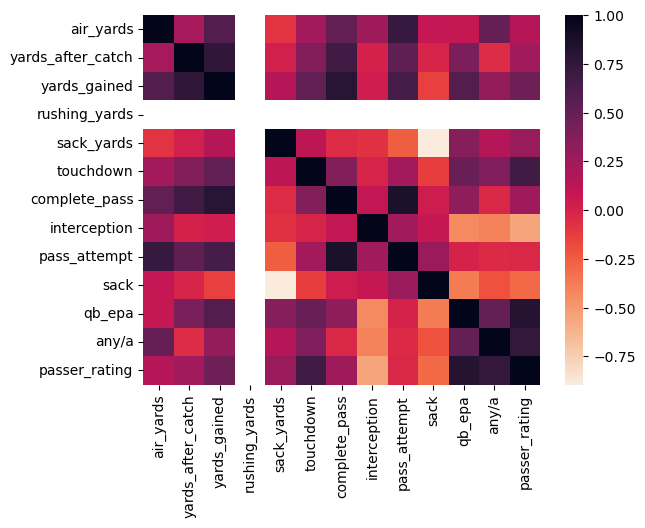

In [ ]:
sns.heatmap(qb_game_data.select_dtypes(include='number').corr(), cmap='rocket_r')